In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [28]:
#Read data set
import pandas as pd
seed = 1

# Read the CSV file into a DataFrame
Admission_data = pd.read_csv("/content/Admission_Predict.csv")

# Factor the variable 'Research' (convert to categorical data)
Admission_data['Research'] = pd.Categorical(Admission_data['Research'])

# Drop the first column
Admission_data.drop(Admission_data.columns[0], axis=1, inplace=True)

# Now you can work with the 'Admission_data' DataFrame
display(Admission_data.head())


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [29]:
from sklearn.tree import DecisionTreeRegressor
# Separate the target variable ('Chance of Admit') and features
X = Admission_data.drop(columns=['Chance of Admit '])
y = Admission_data['Chance of Admit ']
# Create a decision tree model
model = DecisionTreeRegressor(random_state=seed,max_leaf_nodes=8)
# Fit the model to the data
model.fit(X, y)

print("Feature Importances:")
print(model.feature_importances_)


Feature Importances:
[0.0285172 0.        0.        0.        0.        0.9714828 0.       ]


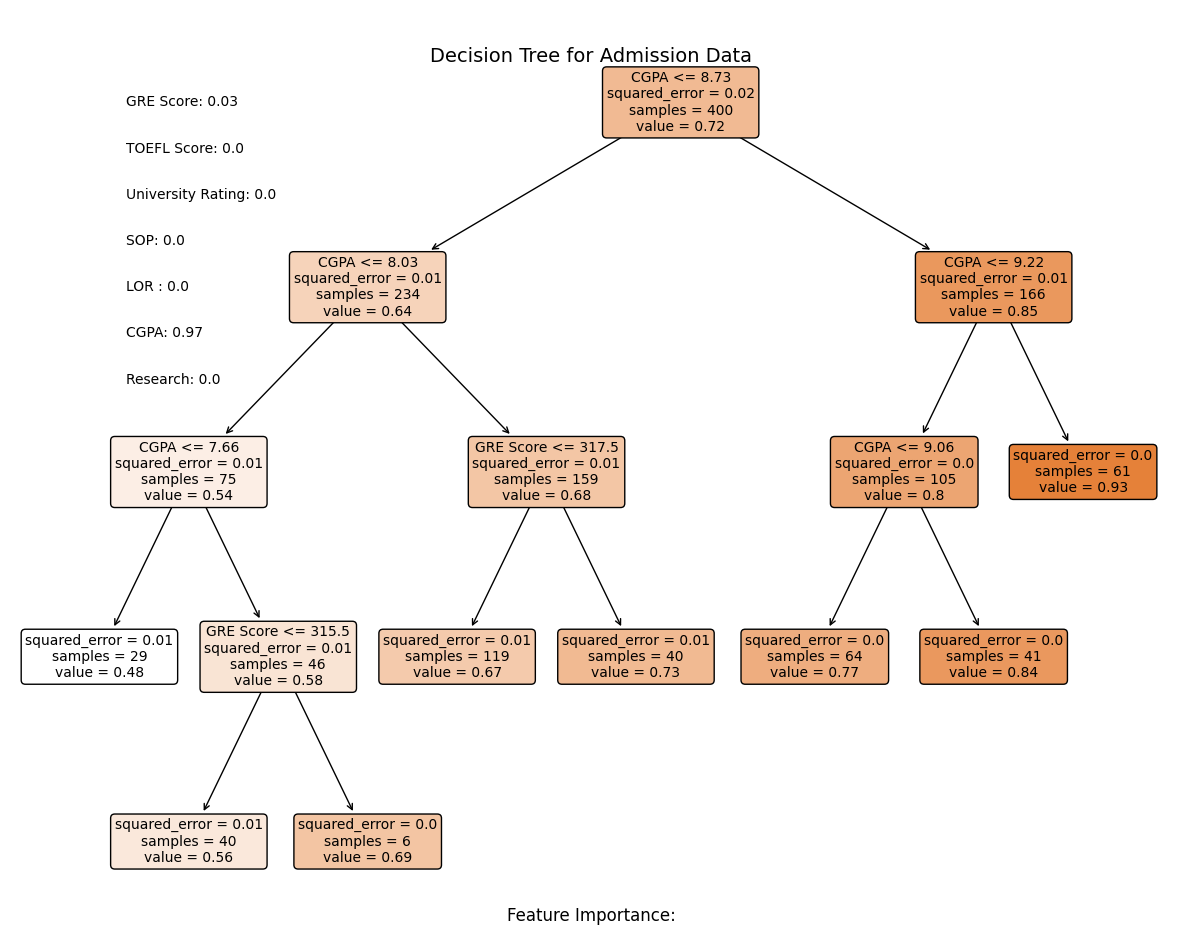

In [30]:
# Plot the decision tree
plt.figure(figsize=(15, 12))
plot_tree(model, feature_names=X.columns, filled=True, fontsize=10, rounded=True, precision=2)

# Add text annotations
plt.text(0.5, 0.95, "Decision Tree for Admission Data", ha='center', va='center', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.5, 0.02, "Feature Importance:", ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
for idx, feature in enumerate(X.columns):
    importance = round(model.feature_importances_[idx], 2)
    plt.text(0.1, 0.9 - idx * 0.05, f"{feature}: {importance}", ha='left', va='center', fontsize=10, transform=plt.gca().transAxes)

plt.show()

In [31]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

seed = 1
np.random.seed(seed)
# Perform LOOCV and get cross-validated predictions
y_pred_loocv = cross_val_predict(model, X, y, cv=len(X))

# Calculate the Mean Squared Error (MSE) for LOOCV
mse_loocv = mean_squared_error(y, y_pred_loocv)

print("LOOCV Mean Squared Error (MSE):", mse_loocv)

LOOCV Mean Squared Error (MSE): 0.0056720014678197424


Best pruned tree size: 6


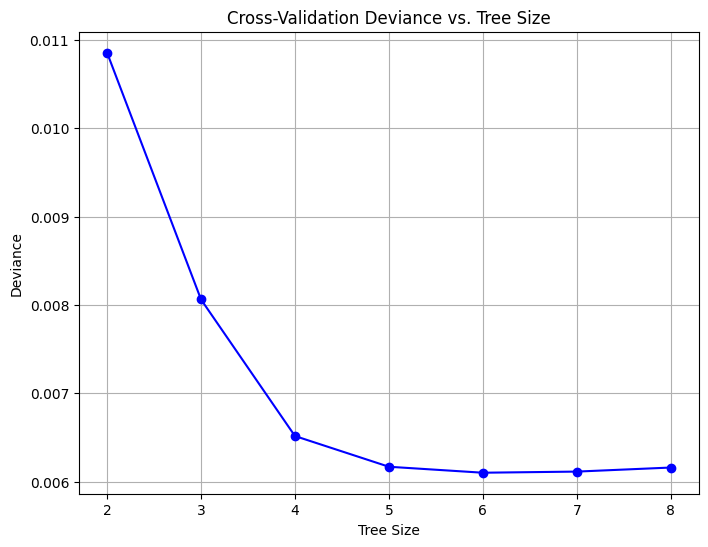

In [32]:
#Pruning
from sklearn.model_selection import KFold

# Define the range of tree sizes (pruning levels) to test
tree_sizes = range(2, 9)  # For example, test sizes from 1 to 8

# Perform cross-validation using K-Fold with K=10
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

# Store the mean squared errors for different tree sizes
mse_scores = []
tree_sizes_cv = []
deviance_cv = []

# Iterate through different tree sizes and perform cross-validation
for size in tree_sizes:
    mse_score = []
    deviance_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = DecisionTreeRegressor(random_state=seed, max_leaf_nodes=size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_score.append(mse)
        deviance = np.mean((y_test - y_pred) ** 2)
        deviance_scores.append(deviance)

    # Calculate the mean of the MSE scores for the current tree size
    mse_mean = np.mean(mse_score)
    mse_scores.append(mse_mean)

    # Calculate the average deviance for the current tree size
    mean_deviance = np.mean(deviance_scores)

    # Store tree size and mean deviance
    tree_sizes_cv.append(size)
    deviance_cv.append(mean_deviance)

# Find the index of the best-pruned tree (lowest MSE score)
best_pruned_idx = np.argmin(mse_scores)
best_pruned_size = tree_sizes[best_pruned_idx]

print("Best pruned tree size:", best_pruned_size)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(tree_sizes_cv, deviance_cv, marker='o', linestyle='-', color='b')
plt.xlabel('Tree Size')
plt.ylabel('Deviance')
plt.title('Cross-Validation Deviance vs. Tree Size')
plt.grid(True)
plt.show()

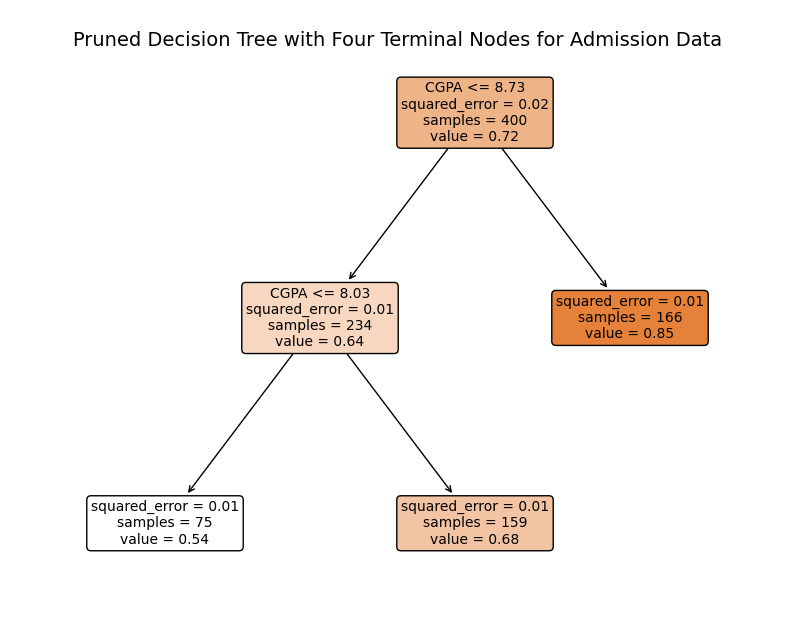

In [33]:
pruned_model = DecisionTreeRegressor(random_state=seed, max_leaf_nodes=3)
pruned_model.fit(X, y)

# Plot the pruned decision tree
plt.figure(figsize=(10, 8))
plot_tree(pruned_model, feature_names=X.columns, filled=True, fontsize=10, rounded=True, precision=2)

# Add text annotations
plt.text(0.5, 0.95, "Pruned Decision Tree with Four Terminal Nodes for Admission Data", ha='center', va='center', fontsize=14, transform=plt.gca().transAxes)

plt.show()


In [34]:
#LOOCV for pruned tree with 4 nodes
# List to store predicted target values for each iteration
from sklearn.model_selection import LeaveOneOut
y_pred_loocv1b = []

seed = 1

# Initialize Leave-One-Out Cross-Validation
loocv = LeaveOneOut()

# Perform Leave-One-Out Cross-Validation with pruning
for train_idx, test_idx in loocv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create a new model and fit it on the current training set
    model = DecisionTreeRegressor(random_state=seed, max_leaf_nodes=3)
    model.fit(X_train, y_train)

    # Prune the tree using the test set
    y_pred = model.predict(X_test)

    # Store the predicted target value for the current test sample
    y_pred_loocv1b.append(y_pred[0])

# Calculate the Mean Squared Error (MSE) for LOOCV with pruning
mse_loocv1b = mean_squared_error(y, y_pred_loocv1b)

print("LOOCV with Pruning Mean Squared Error (MSE):", mse_loocv1b)


LOOCV with Pruning Mean Squared Error (MSE): 0.0078105076845787465


In [35]:
#Random forest

from sklearn.ensemble import RandomForestRegressor
seed = 1

# Create a random forest model with mtry=7 and ntree=1000
model = RandomForestRegressor(n_estimators=1000, max_features=7, random_state=seed)
# Fit the model to the data
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

display(importance_df)

,Feature,Importance
5,CGPA,0.796615
0,GRE Score,0.083629
1,TOEFL Score,0.035223
3,SOP,0.030768
4,LOR,0.027046
2,University Rating,0.014253
6,Research,0.012466


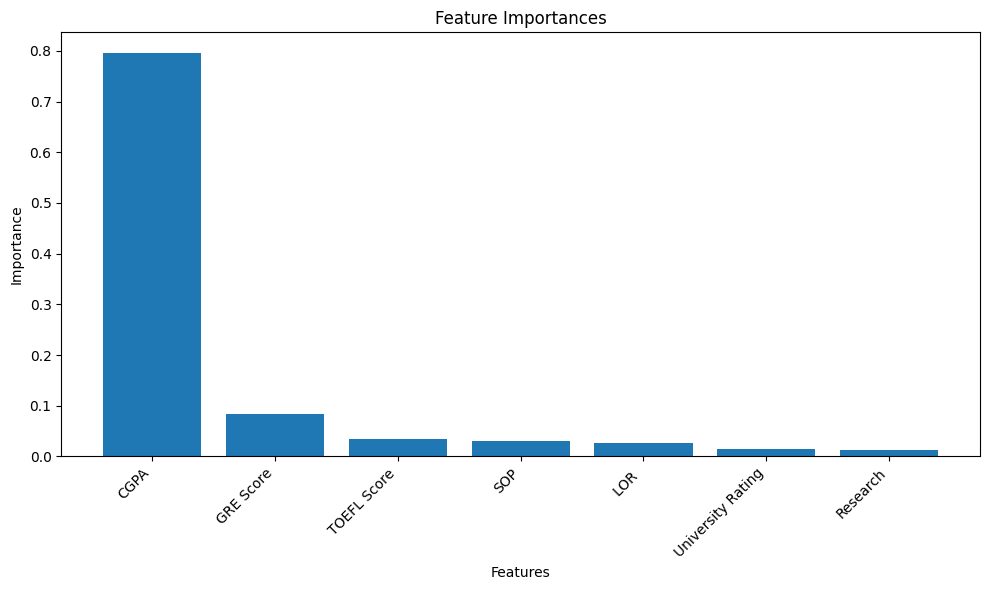

In [36]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [37]:
# Initialize Leave-One-Out Cross-Validation
loocv = LeaveOneOut()

# List to store predicted target values for each iteration
y_pred_loocv1c = []

# Perform Leave-One-Out Cross-Validation with random forests
for train_idx, test_idx in loocv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create a new model and fit it on the current training set
    model = RandomForestRegressor(n_estimators=1000, max_features=7, random_state=seed)
    model.fit(X_train, y_train)

    # Predict the target value using the test set
    y_pred = model.predict(X_test)

    # Store the predicted target value for the current test sample
    y_pred_loocv1c.append(y_pred[0])

# Calculate the Mean Squared Error (MSE) for LOOCV with random forests
mse_loocv1c = mean_squared_error(y, y_pred_loocv1c)

print("LOOCV with Random Forests Mean Squared Error (MSE):", mse_loocv1c)

LOOCV with Random Forests Mean Squared Error (MSE): 0.0048826710090000185


In [38]:
from sklearn.ensemble import RandomForestRegressor
num_features_per_split = round(X.shape[1] / 3)

# Create a random forest model with mtry=7/3 and ntree=1000
model = RandomForestRegressor(n_estimators=1000, max_features=num_features_per_split, random_state=seed)
# Fit the model to the data
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

display(importance_df)

,Feature,Importance
5,CGPA,0.355243
0,GRE Score,0.220562
1,TOEFL Score,0.170987
2,University Rating,0.086538
3,SOP,0.072650
4,LOR,0.063673
6,Research,0.030348


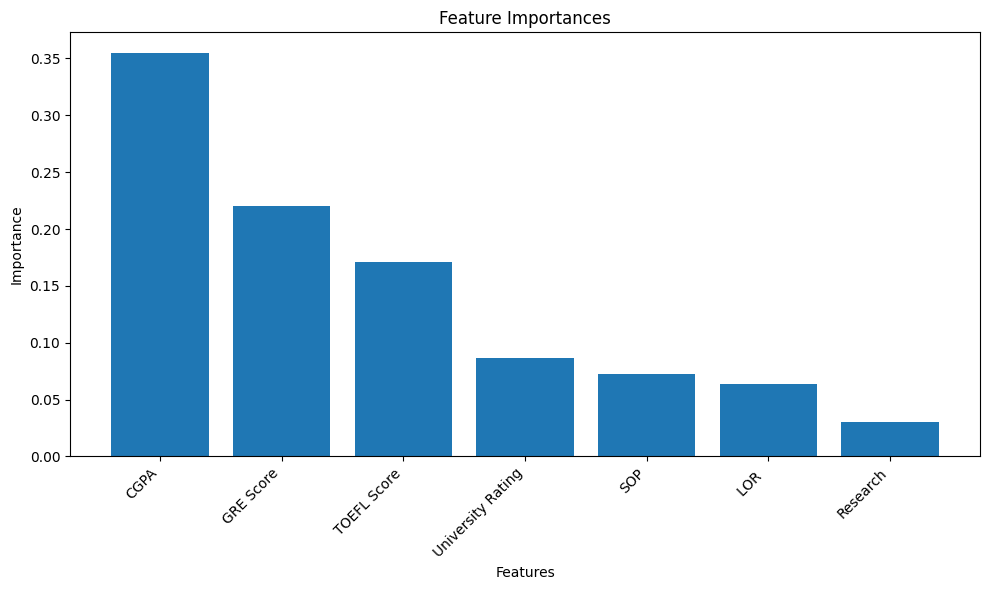

In [39]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [40]:
# Calculate the number of features to use per split (approximately 7/3 of total features)
num_features_per_split = round( X.shape[1] / 3)

# Initialize Leave-One-Out Cross-Validation
loocv = LeaveOneOut()

# List to store predicted target values for each iteration
y_pred_loocv1d = []

# Perform Leave-One-Out Cross-Validation with random forests
for train_idx, test_idx in loocv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create a new random forest model with the calculated number of features and ntree=1000
    model = RandomForestRegressor(n_estimators=1000, max_features=num_features_per_split, random_state=seed)

    # Fit the model on the current training set
    model.fit(X_train, y_train)

    # Predict the target value using the test set
    y_pred = model.predict(X_test)

    # Store the predicted target value for the current test sample
    y_pred_loocv1d.append(y_pred[0])

# Calculate the Mean Squared Error (MSE) for LOOCV with random forests
mse_loocv1d = mean_squared_error(y, y_pred_loocv1d)

print("LOOCV with Random Forests Mean Squared Error (MSE):", mse_loocv1d)


LOOCV with Random Forests Mean Squared Error (MSE): 0.004401870290499988


In [41]:
from sklearn.ensemble import GradientBoostingRegressor
# Create the Gradient Boosting Regressor
gbm_regressor = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=0.01, random_state=seed)

# Fit the model to the data
gbm_regressor.fit(X, y)
# Access the feature importances
feature_importances = gbm_regressor.feature_importances_

# Print the feature importances
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

# Access the training score (R-squared)
train_score = gbm_regressor.score(X, y)

print(f"\nTraining R-squared: {train_score}")

Feature Importances:
GRE Score: 0.18752695536178673
TOEFL Score: 0.025888433075934768
University Rating: 0.0066775320354382625
SOP: 0.0005183004561680267
LOR : 0.03417180985170346
CGPA: 0.7313672210491836
Research: 0.013849748169785063

Training R-squared: 0.8258460739788851


In [42]:
# Initialize Leave-One-Out Cross-Validation
loocv = LeaveOneOut()

# List to store predicted target values for each iteration
y_pred_loocv1e = []

# Perform Leave-One-Out Cross-Validation with Gradient Boosting
for train_idx, test_idx in loocv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create a new Gradient Boosting Regressor
    gbm_regressor = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=0.01, random_state=seed)

    # Fit the model on the current training set
    gbm_regressor.fit(X_train, y_train)

    # Predict the target value using the test set
    y_pred = gbm_regressor.predict(X_test)

    # Store the predicted target value for the current test sample
    y_pred_loocv1e.append(y_pred[0])

# Calculate the Mean Squared Error (MSE) for LOOCV with Gradient Boosting
mse_loocv1e = mean_squared_error(y, y_pred_loocv1e)

print("LOOCV with Gradient Boosting Mean Squared Error (MSE):", mse_loocv1e)


LOOCV with Gradient Boosting Mean Squared Error (MSE): 0.004526951255781969


In [43]:
# Sample data for the table
test_MSE = {
    'Method': ["un-pruned tree" , "pruned tree" , " bagging" ,"random-forest" ,"boosting"],
    'Test MSE': [0.005672,0.006427, 0.004883, 0.004402, 0.004527],
}

# Create a DataFrame from the data dictionary
df_MSE = pd.DataFrame(test_MSE)

# Display the DataFrame (table)
display(df_MSE)

,Method,Test MSE
0,un-pruned tree,0.005672
1,pruned tree,0.006427
2,bagging,0.004883
3,random-forest,0.004402
4,boosting,0.004527
